In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import yfinance as yf
from tqdm import tqdm

## Data description
Market Hours and Timezone
Data is available for all U.S. market sessions, which are segmented into pre-market, regular market, and after-hours:<br><br>

**Pre-Market Trading Hours**: From 4:00 AM to 9:30 AM Eastern Time (ET). **(UTC-5)**<br>
**Regular Market Hours**: From 9:30 AM to 4:00 PM ET.<br>
**After-Hours Trading**: From 4:00 PM to 8:00 PM ET.<br><br>
All data is standardized to Eastern Time (ET), aligning with the primary trading hours of the U.S. stock markets. <br>This standardization facilitates ease of integration and consistency in data analysis, particularly for time-sensitive trading strategies.<br>

https://polygon.io/docs/rest/stocks/overview#market-hours-and-timezone

In [2]:
file = '/Users/vav/Work/thesis_2025/ts_llm_prediction/data/AAPL_30_minute_stock_prices.csv'

df = pd.read_csv(file)
ticker = df['ticker'].values[0]

print(f'Data Size: {df.shape[0]} x {df.shape[1]}')
df.head()

Data Size: 79234 x 10


,open,high,low,close,volume,vwap,timestamp,transactions,otc,ticker
0,31.5950,31.6425,31.5825,31.5925,25760.0,31.5954,1427097600000,23,NaN,AAPL
1,31.5925,31.6475,31.5750,31.6475,10500.0,31.6125,1427099400000,11,NaN,AAPL
2,31.6475,31.6625,31.6325,31.6625,12780.0,31.6484,1427101200000,15,NaN,AAPL
3,31.6700,31.6850,31.6350,31.6850,9760.0,31.6598,1427103000000,24,NaN,AAPL
4,31.6600,31.6750,31.6350,31.6450,54844.0,31.6556,1427104800000,32,NaN,AAPL


In [3]:
df.isnull().sum()

open                0
high                0
low                 0
close               0
volume              0
vwap                0
timestamp           0
transactions        0
otc             79234
ticker              0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79234 entries, 0 to 79233
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open          79234 non-null  float64
 1   high          79234 non-null  float64
 2   low           79234 non-null  float64
 3   close         79234 non-null  float64
 4   volume        79234 non-null  float64
 5   vwap          79234 non-null  float64
 6   timestamp     79234 non-null  int64  
 7   transactions  79234 non-null  int64  
 8   otc           0 non-null      float64
 9   ticker        79234 non-null  object 
dtypes: float64(7), int64(2), object(1)
memory usage: 6.0+ MB


# Data Exploration

In [5]:
df['time'] = pd.to_datetime(df['timestamp'], unit='ms')
ts=df[['time', 'close']]

ts.head()

,time,close
0,2015-03-23 08:00:00,31.5925
1,2015-03-23 08:30:00,31.6475
2,2015-03-23 09:00:00,31.6625
3,2015-03-23 09:30:00,31.6850
4,2015-03-23 10:00:00,31.6450


## Check if any missing time observations

In [6]:
ts = ts.sort_values(by=['time'], ascending=True)
ts['minutes'] = ts['time'].dt.time.astype(str)

print('Unique intraday timestaps')
ts['minutes'].unique()

Unique intraday timestaps


array(['08:00:00', '08:30:00', '09:00:00', '09:30:00', '10:00:00',
       '10:30:00', '11:00:00', '11:30:00', '12:00:00', '12:30:00',
       '13:00:00', '13:30:00', '14:00:00', '14:30:00', '15:00:00',
       '15:30:00', '16:00:00', '16:30:00', '17:00:00', '17:30:00',
       '18:00:00', '18:30:00', '19:00:00', '19:30:00', '20:00:00',
       '20:30:00', '21:00:00', '21:30:00', '22:00:00', '22:30:00',
       '23:00:00', '23:30:00', '00:00:00', '00:30:00', '07:30:00'],
      dtype=object)

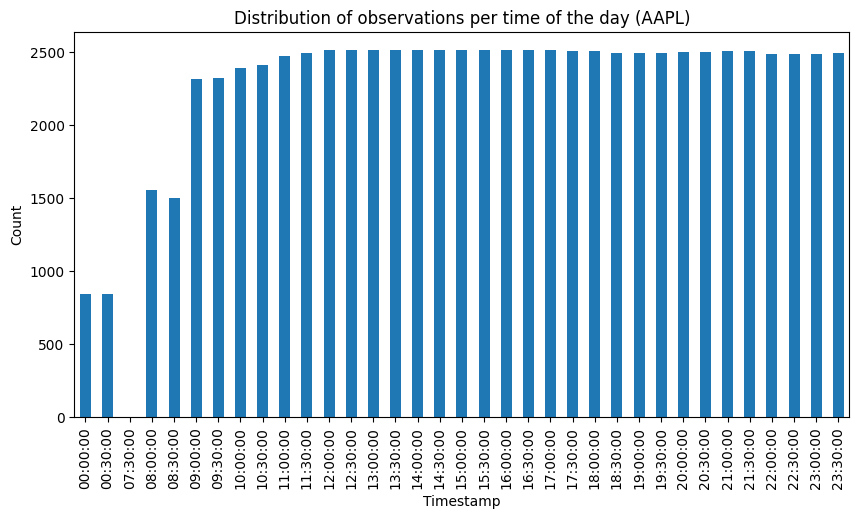

In [7]:
time_counts = ts.groupby(by =['minutes'])['close'].count()

plt.figure(figsize=(10, 5))
ax = time_counts.plot.bar()
plt.title(f"Distribution of observations per time of the day ({ticker})")
plt.xlabel("Timestamp")
plt.ylabel("Count")
plt.show()

### Time gaps in minutes/hours

In [8]:
# Take observations after 09:00 only
ts = ts[ts['minutes'] > '08:30:00'].reset_index(drop=True)

# Calculation of minute gaps
ts['time_diff_in_mins'] = ts['time'].diff().dt.total_seconds().div(60).fillna(0).astype(int)
ts['time_diff_in_hours'] = (ts['time'].diff().dt.total_seconds() / 3600).fillna(0).astype(float)


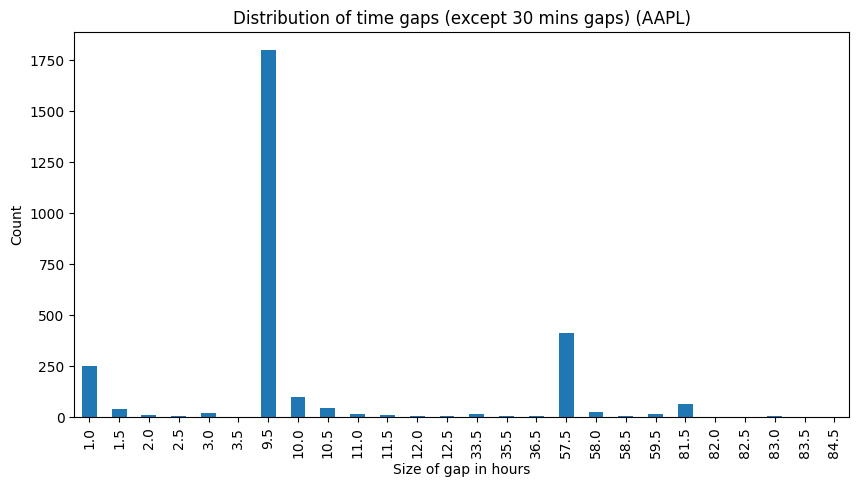

In [9]:
# gap_counts = ts[ts['time_diff_in_mins'] > 30].groupby(by =['time_diff_in_mins'])['close'].count()

gap_counts = ts[ts['time_diff_in_hours'] > 0.5].groupby(by =['time_diff_in_hours'])['close'].count()

plt.figure(figsize=(10, 5))
ax = gap_counts.plot.bar()
plt.title(f"Distribution of time gaps (except 30 mins gaps) ({ticker})")
plt.xlabel("Size of gap in hours")
plt.ylabel("Count")
plt.show()

**NOTE:** 
- 9.5h gap - is night
- 57.5 gap - is weekend

All other gaps require imputation

### Let's fill in the gaps

In [10]:
def add_missing_rows(raw_ts:pd.DataFrame, freq:str)->pd.DataFrame:
    dates = raw_ts['time'].dt.date.astype('str').unique()
    start, end = dates.min(), dates.max()

    batch = yf.Tickers(['SPY']).download(start=start, end=end).reset_index() #get all working days from YFinance (looking at SPY index)

    all_time = pd.DataFrame(data = {'time': pd.date_range(start=start, end=end, freq='30min')})
    all_time['date'] = all_time['time'].dt.date.astype(str)
    all_time = all_time[all_time['date'].isin(batch['Date'].dt.date.astype(str))]
    all_time['minutes'] = all_time['time'].dt.time.astype(str)
    all_time = all_time[all_time['minutes']>='09:00:00']

    ts = all_time[['time']].merge(raw_ts, how='left', on=['time'])
    return ts


In [11]:
size_before = len(ts)
ts = add_missing_rows(raw_ts=ts, freq='30min')[['time', 'close']]
size_after = len(ts)

print(f'Added: {size_after - size_before} missed timestamps')
print(f'# NULL values: {ts["close"].isnull().sum()}')

ts.head()

[*********************100%***********************]  1 of 1 completed


Added: 866 missed timestamps
# NULL values: 896


,time,close
0,2015-03-23 09:00:00,31.6625
1,2015-03-23 09:30:00,31.6850
2,2015-03-23 10:00:00,31.6450
3,2015-03-23 10:30:00,31.6275
4,2015-03-23 11:00:00,31.6500


### Let's fill in the gaps with AVG of two closeses non-null values

In [12]:
ts['bfill_close'] = ts['close'].bfill()
ts['ffill_close'] = ts['close'].ffill()

ts['filled_close'] = ts[['ffill_close', 'bfill_close']].mean(axis=1)

ts[ts['close'].isnull()].head()

,time,close,bfill_close,ffill_close,filled_close
180,2015-03-31 09:00:00,NaN,31.4700,31.6125,31.54125
181,2015-03-31 09:30:00,NaN,31.4700,31.6125,31.54125
210,2015-04-01 09:00:00,NaN,31.1075,31.1325,31.12000
271,2015-04-06 09:30:00,NaN,31.1425,31.1250,31.13375
480,2015-04-15 09:00:00,NaN,31.6875,31.5925,31.64000


In [13]:
ts['close'] = ts['close'].fillna(ts['filled_close'])

print(f'# NULL values: {ts["close"].isnull().sum()}')
print(f'# Duplicated values: {len(ts) - len(ts.drop_duplicates(subset=["time"]))}')

# NULL values: 0
# Duplicated values: 0


# Visualisations of primarily processed data

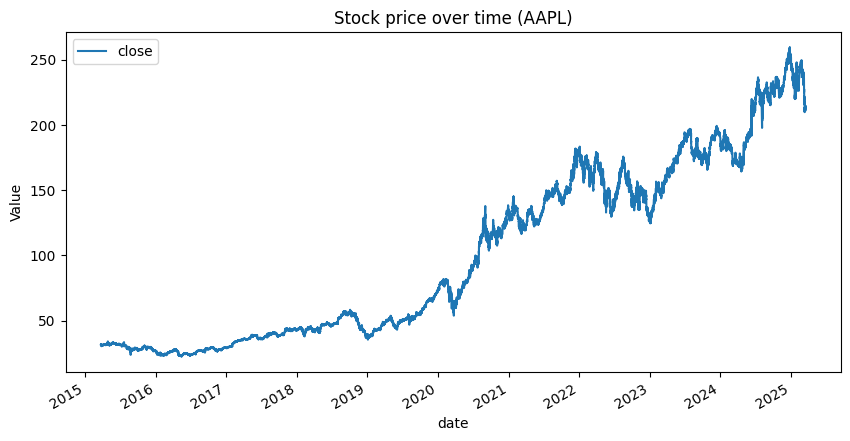

In [14]:
ts = ts[['time', 'close']]

ax = ts.plot(x='time', y='close', kind='line', figsize=(10, 5))

plt.title(f"Stock price over time ({ticker})")
plt.xlabel("date")
plt.ylabel("Value")
plt.show()

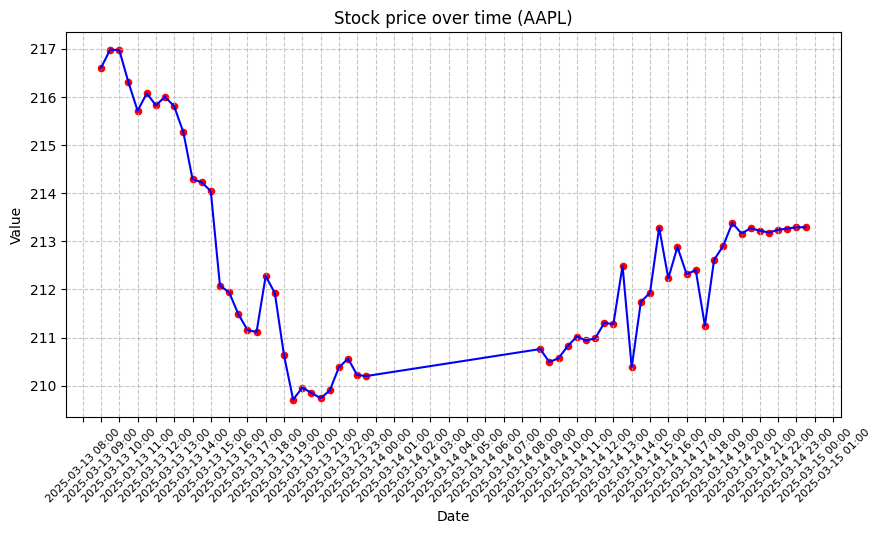

In [15]:
sample = ts[(ts['time'] >= '2025-03-13 09:00:00') & (ts['time'] <= '2025-03-15 00:00:00')]
ax = sample.plot(x='time', y='close', kind='scatter', figsize=(10, 5), color='red')


plt.plot(sample['time'], sample['close'], linestyle='-', color='blue')


ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.xticks(rotation=45, fontsize=8)
plt.grid(True, linestyle='--', alpha=0.7)

plt.title(f"Stock price over time ({ticker})")
plt.xlabel("Date")
plt.ylabel("Value")

plt.show()

# Transformations 🤖

ADF Statistic: -0.17464494417075244
p-value: 0.9414771598363426
Critical Values:
1%, -3.430436849714391
Critical Values:
5%, -2.8615783860743154
Critical Values:
10%, -2.566790431588318


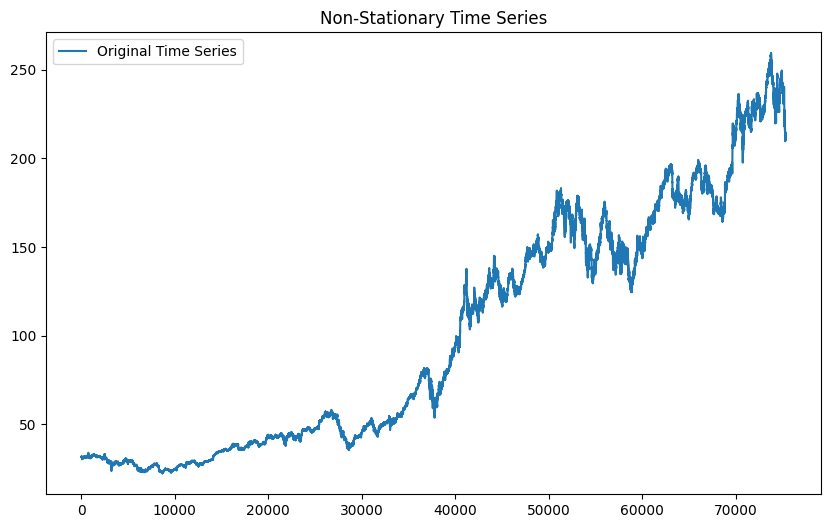

In [17]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(ts['close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critical Values:')
    print(f'{key}, {value}')

plt.figure(figsize=(10, 6))
plt.plot(ts['close'], label='Original Time Series')
plt.title('Non-Stationary Time Series')
plt.legend()
plt.show()

ADF Statistic (Differenced): -35.19421622314821
p-value (Differenced): 0.0
Critical Values (Differenced):
1%, -3.4304368520213884
Critical Values (Differenced):
5%, -2.8615783870939535
Critical Values (Differenced):
10%, -2.566790432131039


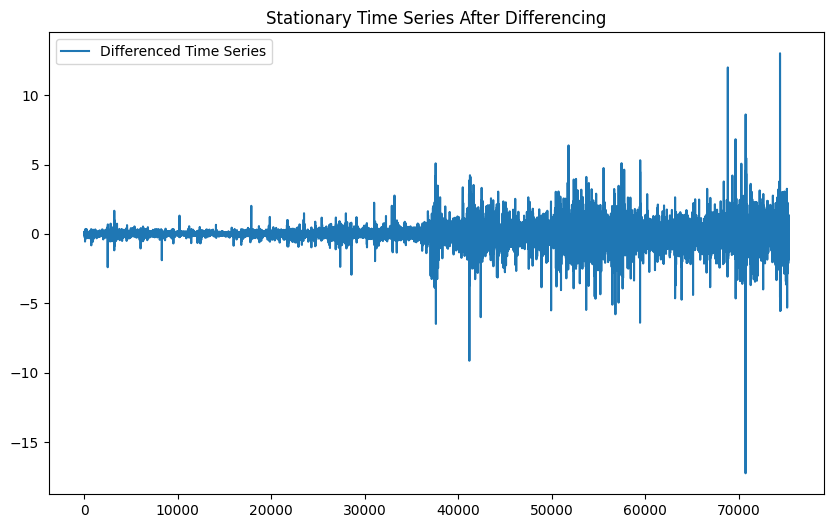

In [18]:
diff_series = np.diff(ts['close'], n=1)

result_diff = adfuller(diff_series)
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])
for key, value in result_diff[4].items():
    print('Critical Values (Differenced):')
    print(f'{key}, {value}')

plt.figure(figsize=(10, 6))
plt.plot(diff_series, label='Differenced Time Series')
plt.title('Stationary Time Series After Differencing')
plt.legend()
plt.show()

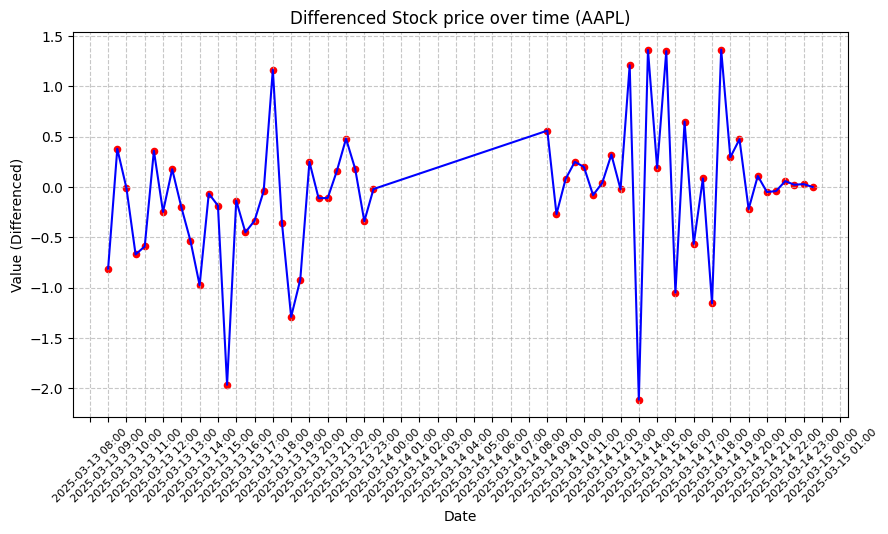

In [26]:
ts['diff'] = [0] + diff_series.tolist()
sample = ts[(ts['time'] >= '2025-03-13 09:00:00') & (ts['time'] <= '2025-03-15 00:00:00')]
ax = sample.plot(x='time', y='diff', kind='scatter', figsize=(10, 5), color='red')


plt.plot(sample['time'], sample['diff'], linestyle='-', color='blue')


ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.xticks(rotation=45, fontsize=8)
plt.grid(True, linestyle='--', alpha=0.7)

plt.title(f"Differenced Stock price over time ({ticker})")
plt.xlabel("Date")
plt.ylabel("Value (Differenced)")

plt.show()